In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install joblib tensorflow

In [3]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [4]:
root = "/content/drive/MyDrive/Bitcoin/"

# Load train/test LSTM sequences
X_train = np.load(f"{root}preprocessed/X_train_lstm.npy")
y_train = np.load(f"{root}preprocessed/y_train_lstm.npy")
X_test  = np.load(f"{root}preprocessed/X_test_lstm.npy")
y_test  = np.load(f"{root}preprocessed/y_test_lstm.npy")

# Load feature metadata
feature_info = joblib.load(f"{root}preprocessed/feature_info.pkl")
seq_len = feature_info["seq_length"]
num_features = len(feature_info["scaled_features"])

print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (2273, 7, 15)  Test: (570, 7, 15)


In [5]:
def build_lstm():
    inputs = keras.Input(shape=(seq_len, num_features))
    x = layers.LSTM(64, dropout=0.1)(inputs)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=tf.keras.losses.Huber())

    return model

In [6]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [12]:
tscv = TimeSeriesSplit(n_splits=5)
lstm_preds_train = np.full(len(X_train), np.nan)

print("\nGenerating OOS LSTM predictions with TimeSeriesSplit...\n")

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold+1}: Train {tr_idx[0]}:{tr_idx[-1]},  Val {val_idx[0]}:{val_idx[-1]}")

    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]

    model = build_lstm()

    model.fit(
        X_tr, y_tr,
        epochs=100,
        batch_size=16,
        shuffle=False,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, lr_scheduler],
        verbose=0
    )

    preds = model.predict(X_val, verbose=0).flatten()
    lstm_preds_train[val_idx] = preds

print("\nOOS LSTM predictions generated.")


Generating OOS LSTM predictions with TimeSeriesSplit...

Fold 1: Train 0:382,  Val 383:760

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 25: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Fold 2: Train 0:760,  Val 761:1138

Epoch 15: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 30: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Fold 3: Train 0:1138,  Val 1139:1516

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.24

In [13]:
print("\nTraining final LSTM model on FULL training set...\n")

final_model = build_lstm()

history = final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

lstm_preds_test = final_model.predict(X_test, verbose=0).flatten()
print("\nFinal model trained.")


Training final LSTM model on FULL training set...

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.5405 - val_loss: 0.5177 - learning_rate: 1.0000e-04
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5333 - val_loss: 0.5156 - learning_rate: 1.0000e-04
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5282 - val_loss: 0.5147 - learning_rate: 1.0000e-04
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5279 - val_loss: 0.5148 - learning_rate: 1.0000e-04
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5259 - val_loss: 0.5139 - learning_rate: 1.0000e-04
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5268 - val_loss: 0.5139 - learning_rate: 1.0000e-04
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5256 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5220 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 9/100
128/128 ━━━━━━━

In [14]:
def directional_accuracy(actual, pred):
    return np.mean(np.sign(actual) == np.sign(pred)) * 100

# Directional Accuracy
dir_acc = directional_accuracy(y_test, lstm_preds_test)

# Correlation
correlation = np.corrcoef(y_test, lstm_preds_test)[0, 1]

# R^2
r2 = r2_score(y_test, lstm_preds_test)

# Sharpe Ratio
strategy_returns = np.sign(lstm_preds_test) * y_test
sharpe = strategy_returns.mean() / (strategy_returns.std() + 1e-8)

print(f"Directional Accuracy: {dir_acc:.2f}%")
print(f"Correlation:          {correlation:.4f}")
print(f"R²:                   {r2:.4f}")
print(f"Sharpe Ratio:         {sharpe:.4f}")

Directional Accuracy: 52.63%
Correlation:          0.0226
R²:                   -0.0086
Sharpe Ratio:         -0.0019


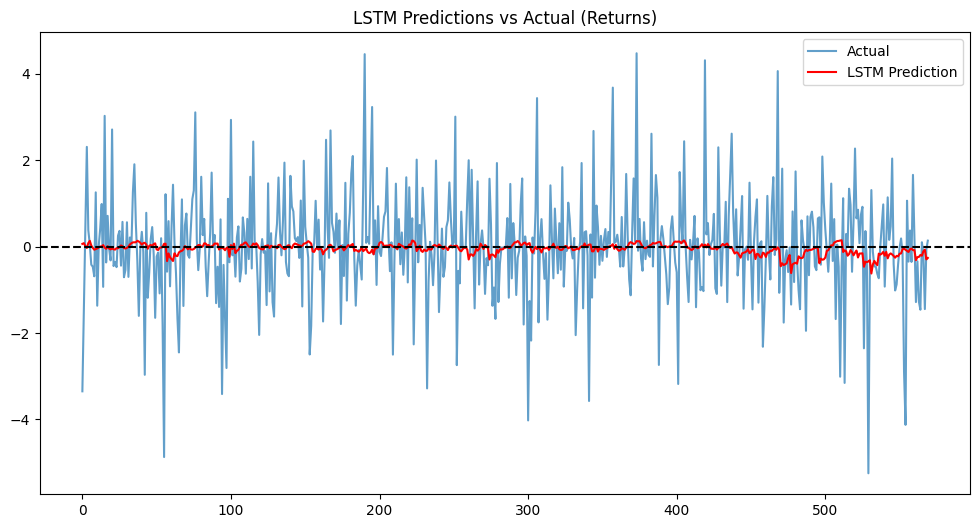

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual", alpha=0.7)
plt.plot(lstm_preds_test, label="LSTM Prediction", color="red")
plt.axhline(0, linestyle="--", color="black")
plt.title("LSTM Predictions vs Actual (Returns)")
plt.legend()
plt.show()

In [16]:
np.save(f"{root}predictions/lstm_train_preds.npy", lstm_preds_train)
np.save(f"{root}predictions/lstm_test_preds.npy", lstm_preds_test)
final_model.save(f"{root}models/lstm_model.h5")

print("\nSaved LSTM predictions & model.")


Saved LSTM predictions & model.
